# Third cohort brain panels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import plotly.express as px
import os
import pickle
import seaborn as sns
from scipy.stats import zscore

In [2]:
number_of_days = 14 #change this values based on number of days
mice = ["466029_f3", "475165_f1", "475165_f3", "475165_f5", "475165_f7"]
HD_mice = ["466029_f3", "475165_f3", "475165_f7"]
WT_mice = ["475165_f1", "475165_f5"]

## load files from folder

In [3]:
def pickle_from_folder(folder_path):
    # Initialize an empty list to store loaded data
    loaded_data = []

    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a pickle file
        if filename.endswith('.pickle'):
            file_path = os.path.join(folder_path, filename)
            try:
                # Open the pickle file in read-binary mode
                with open(file_path, 'rb') as file:
                    # Load the data from the pickle file
                    data = pickle.load(file)
                    loaded_data.append(data)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return loaded_data

In [4]:
# Define the shared folder path
shared_path = "X:/RaymondLab/1_Kai/3_processed_data/2_pickle/stage2"
days = [f"day{i}" for i in range(1, number_of_days + 1)]

In [5]:
#load in mask
from preprocessing_functions import (load_masks)
masking = load_masks()
mask, mask_outline = masking[0], masking[1]
rescaled_image = cv2.resize(mask, (114, 114))
binary_mask = np.where(rescaled_image == 0, np.nan, 1)

In [6]:
#function to load in pickle files
def load_one_day_full(file_path):

    with open(file_path, 'rb') as file:
        # Load the data from the pickle file
        data = pickle.load(file)
        #time_data = np.mean(data, axis=(1, 2))
    
    return data

# average panels functions

In [28]:
#version 8
def average_panels(days, mice, binary_mask, shared_path, flash, success_fail):

    folder_path_full = os.path.join(shared_path, flash, success_fail, "full_frame")
    data_set = []
    
    for mouse in mice:
        day_timeseries = []   
    
        for day in days:

            try:
                file_path_full = f"{folder_path_full}/{mouse}_stage2_{day}_{flash}_{success_fail}_ff.pickle"
                one_day_full = load_one_day_full(file_path_full)
                print(f"Original length for {mouse} on {day}: {len(one_day_full)}")

                z_score_one_day_full = zscore(one_day_full, axis=1)

                # Ensure the first dimension has 100 points by padding with NaNs
                current_length = z_score_one_day_full.shape[0]
                target_length = 100

                if 0 < current_length < target_length:
                    pad_size = target_length - current_length
                    pad_array = np.full((pad_size, *z_score_one_day_full.shape[1:]), np.nan, dtype=z_score_one_day_full.dtype)
                    z_score_one_day_full = np.concatenate([z_score_one_day_full, pad_array], axis=0)
                else:
                    print(f"no datapoint for {mouse} on {day}")
                    # Append an array of NaNs of shape (100, 200, 128, 128) if data is missing
                    z_score_one_day_full = np.full((100, 200, 128, 128), np.nan, dtype=np.float32)

                day_timeseries.append(z_score_one_day_full)

            except FileNotFoundError:
                print(f"File not found for mouse {mouse} on day {day}")
                # Append an array of NaNs of shape (100, 200, 128, 128) if data is missing
                z_score_one_day_full = np.full((100, 200, 128, 128), np.nan, dtype=np.float32)
                day_timeseries.append(z_score_one_day_full)

        # Convert timeseries list into numpy array if needed
        if day_timeseries:
            data_set.append(np.array(day_timeseries))

    print("finished loading files")

    return data_set

In [8]:
#version 2
def plot_average_separate_panels(mice, filename, flash):
    # Define frames and their corresponding times
    frames_to_plot = [1, 8, 15, 22, 30, 38, 45, 52, 60]
    frames_to_seconds = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

    # Loop through the averaged data for each day
    for average_for_day, day in mice:
        print(f"Plotting for {day}")

        if len(average_for_day.shape) == 3:  # Check if it's a 3D array
            cropped_z_score_single_full = average_for_day[:, :-14, 7:-7]
            masked_z_score_single_full = cropped_z_score_single_full * binary_mask

            # Create a figure and subplots
            fig, axes = plt.subplots(1, 9, figsize=(20, 10))

            # Add a title for the entire figure
            fig.suptitle(f"{day} - {flash} flash ({filename})", 
                         color='white', fontsize=30, weight='bold', y=0.7)

            # Plot the specific frames
            for i, ax in enumerate(axes.flatten()):
                if i < len(frames_to_plot):
                    frame_index = frames_to_plot[i]
                
                    # Check if the frame_index is within bounds
                    if frame_index < masked_z_score_single_full.shape[0]:
                        image = masked_z_score_single_full[frame_index]
                        ax.imshow(image, cmap='RdYlBu_r')
                        fig.set_facecolor('#5D6D7D')  # Set background color to black
                        ax.axis('off')
                        ax.set_title(f'{frames_to_seconds[i]} s', color='white', fontsize=40)
                    else:
                        ax.axis('off')  # Hide the axes if the frame index is out of bounds
                else:
                    ax.axis('off')  # Hide the axes for unused subplots

            # Adjust layout
            plt.tight_layout()

            # Save the figure
            #save_file_path = f"X:/RaymondLab/1_Kai/3_processed_data/8_panels/{filename}_{flash}/{filename}_{day}_avg_brain_panels.png"
            #plt.savefig(save_file_path, facecolor=fig.get_facecolor(), bbox_inches='tight')

            # Optionally, you can show the figure if you want
            plt.show()

            # Close the figure to free up memory
            plt.close(fig)


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_separate_panels(averaged_data, filename, flash, binary_mask):
    """
    Plots averaged brain activity panels over time using preprocessed data.
    
    Parameters:
        averaged_data (list of np.ndarray or list of tuples): If tuples, contains (average_for_day, day) data.
        filename (str): Label for saving and identifying plots.
        flash (str): Type of flash used in the experiment.
        binary_mask (np.ndarray): Mask to apply to the data.
    """
    # Define frames and their corresponding times
    frames_to_plot = [1, 8, 15, 22, 30, 38, 45, 52, 60]
    frames_to_seconds = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

    # Check if the data is a list of arrays or tuples
    if isinstance(averaged_data[0], tuple):
        print("Detected tuple format (average_for_day, day). Unpacking.")
        data_pairs = averaged_data  # Data is already in the correct format
    else:
        print("Detected list of arrays. Generating synthetic day labels.")
        data_pairs = [(data, f"Day {i+1}") for i, data in enumerate(averaged_data)]

    for average_for_day, day in data_pairs:
        print(f"Plotting for {day}")

        # Check if the data is valid
        if average_for_day is None or not isinstance(average_for_day, np.ndarray):
            print(f"Skipping {day} due to invalid data.")
            continue

        if len(average_for_day.shape) < 3:
            print(f"Skipping {day} due to incorrect shape: {average_for_day.shape}")
            continue

        # Crop the z-score single full-frame data
        cropped_z_score_single_full = average_for_day[:, :, :, :-14, 7:-7]

        # Apply the binary mask (optional)
        masked_z_score_single_full = np.where(np.isnan(cropped_z_score_single_full), np.nan, cropped_z_score_single_full * binary_mask)

        # Create figure and subplots
        fig, axes = plt.subplots(1, len(frames_to_plot), figsize=(20, 10))
        fig.suptitle(f"{day} - {flash} flash ({filename})", 
                     color='white', fontsize=30, weight='bold', y=0.7)

        # Plot the specific frames
        for i, ax in enumerate(axes.flatten()):
            frame_index = frames_to_plot[i]
            
            # Ensure the frame index is within bounds
            if frame_index < masked_z_score_single_full.shape[0]:
                image = masked_z_score_single_full[frame_index]
                ax.imshow(image, cmap='RdYlBu_r')
                fig.set_facecolor('#5D6D7D')  # Background color
                ax.axis('off')
                ax.set_title(f'{frames_to_seconds[i]} s', color='white', fontsize=40)
            else:
                ax.axis('off')  # Hide unused subplots

        plt.tight_layout()

        # Show the figure
        plt.show()

        # Close to free memory
        plt.close(fig)

# WT single fail

In [29]:
WT_single_fail = average_panels(days, WT_mice, binary_mask, shared_path, "single", "fail")

Original length for 475165_f1 on day1: 0
no datapoint for 475165_f1 on day1
Original length for 475165_f1 on day2: 3
Original length for 475165_f1 on day3: 7
File not found for mouse 475165_f1 on day day4
Original length for 475165_f1 on day5: 8
Original length for 475165_f1 on day6: 15
Original length for 475165_f1 on day7: 18
File not found for mouse 475165_f1 on day day8
Original length for 475165_f1 on day9: 11
Original length for 475165_f1 on day10: 18
Original length for 475165_f1 on day11: 19
Original length for 475165_f1 on day12: 2
Original length for 475165_f1 on day13: 21
Original length for 475165_f1 on day14: 0
no datapoint for 475165_f1 on day14
Original length for 475165_f5 on day1: 15
Original length for 475165_f5 on day2: 14
Original length for 475165_f5 on day3: 10
File not found for mouse 475165_f5 on day day4
Original length for 475165_f5 on day5: 1
Original length for 475165_f5 on day6: 18
Original length for 475165_f5 on day7: 19
Original length for 475165_f5 on d

In [36]:
WT_single_fail_avg = averaged_dataset = np.nanmean(WT_single_fail_avg, axis=0)  # Averages across mice
print("New shape after averaging:", averaged_dataset.shape)  # Expected: (14, 100, 200, 128, 128)

C:\Users\trapped\AppData\Local\Temp\ipykernel_4232\120268942.py:1: RuntimeWarning: Mean of empty slice
  WT_single_fail_avg = averaged_dataset = np.nanmean(WT_single_fail_avg, axis=0)  # Averages across mice


New shape after averaging: (14, 100, 200, 128, 128)


Detected list of arrays. Generating synthetic day labels.
Plotting for Day 1


TypeError: Invalid shape (100, 200, 114, 114) for image data

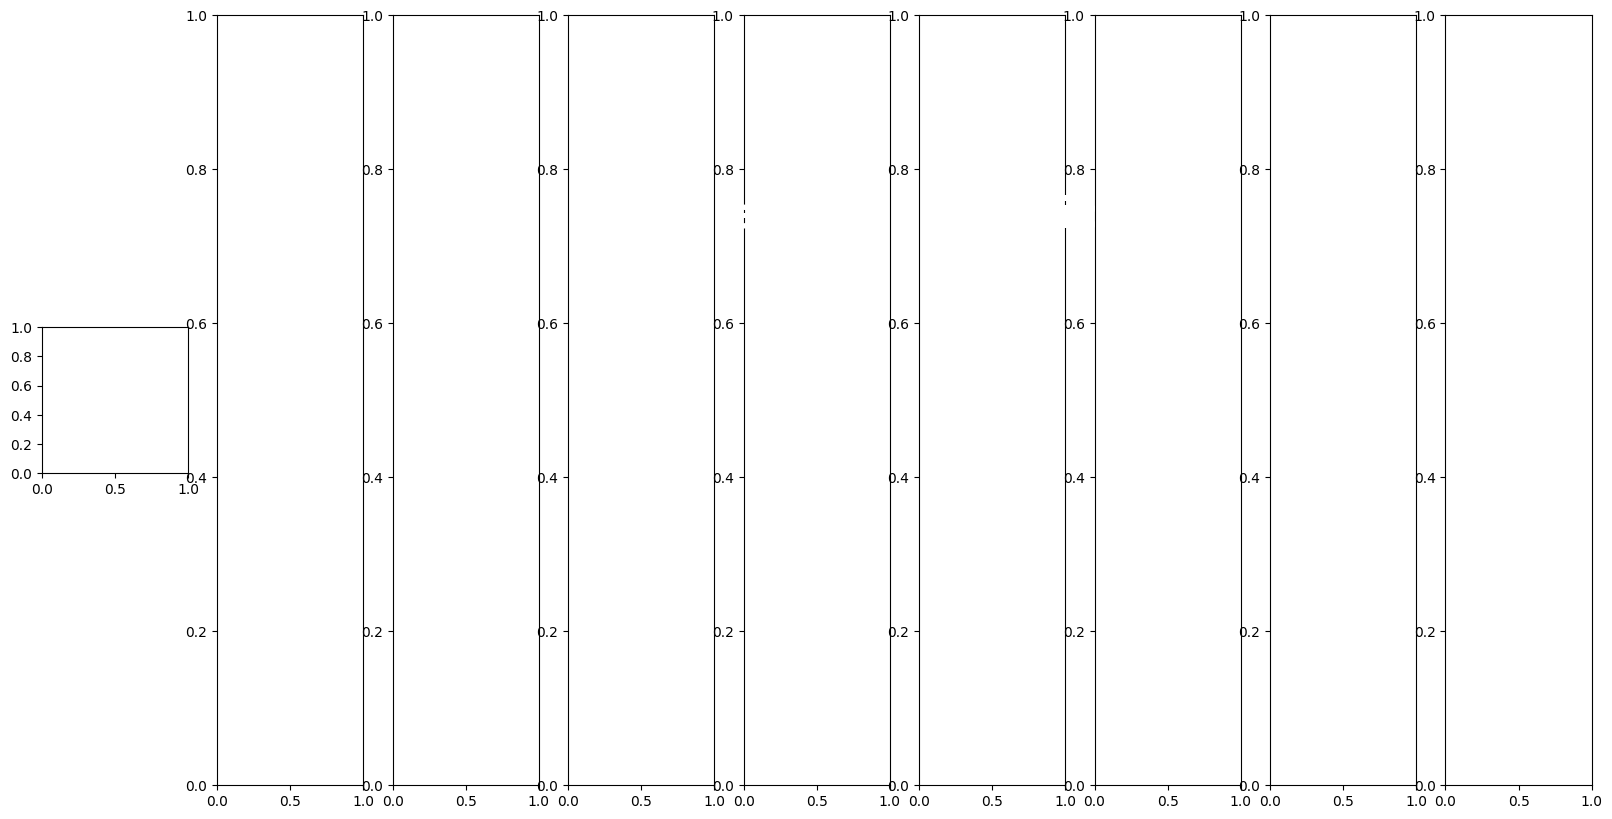

In [20]:
#plot_average_separate_panels(WT_single_fail_avg, filename="female_WT_stage2", flash="single")
plot_average_separate_panels(WT_single_fail_avg, "WT_mice", "single", binary_mask)

<class 'list'>
2
<class 'numpy.ndarray'>


# WT single success

In [ ]:
WT_averaged = average_panels(days, WT_mice, binary_mask, shared_path, "single", "success")

In [ ]:
plot_average_separate_panels(WT_averaged, filename="female_WT_stage2", flash="single")

# HD single

In [ ]:
HD_averaged = average_panels(days, HD_mice, binary_mask, shared_path, "single")

In [ ]:
plot_average_separate_panels(HD_averaged, "female_HD_stage2", flash="single")

# WT double averaged

In [ ]:
WT_d_averaged = average_panels(days, WT_mice, binary_mask, shared_path, "double")

In [ ]:
plot_average_separate_panels(WT_d_averaged, filename="female_WT_stage2", flash="double")

In [ ]:
HD_d_averaged = average_panels(days, HD_mice, binary_mask, shared_path, "double")

In [ ]:
plot_average_separate_panels(HD_d_averaged, filename="female_HD_stage2", flash="double")

# double individual

In [ ]:
one_mice = []
for mouse in mice:
    one_mouse = []
    one_mice.append(one_mouse)
    for day in days:
        folder_path = os.path.join(shared_path, day, "double", "v1")
        file_path = f"{folder_path}/{mouse}_stage2_{day}_double_v1.pickle"
        try:
            one_day = load_one_day(file_path)
            one_mouse.append(one_day)
        except FileNotFoundError:
            one_mouse.append(np.zeros(len(one_day)))
            print(f"File not found for mouse {mouse} on day {day}")

In [ ]:
for mouse_id, mouse_data in zip(mice, one_mice):
    sns.set_theme()
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(mouse_data, cmap="jet")
    ax.set_yticklabels([str(i) for i in range(1, len(mouse_data) + 1)])
    ax.set(xlabel="frames (30fps)", ylabel="day", title=f"Double Flash - Mouse {mouse_id}")

    # Display the plot
    plt.show()